# Wind Speed Distributions

The DWD provides wind data (speed and direction) time series in several temporal resolutions. This example uses hourly data recorded at station "Kahler Asten". Kahler Asten is the highest mountain in NRW (841.9 m).

The data stored in a ZIP archive has been downloaded before from the DWD FTP server. 

Steps:

1. Find the ZIP file in the data directory.
1. Extract the wind data file from the ZIP archive. The data file name starts with `produkt_ff_...`.
1. Read the data into a pandas dataframe. Convert the time stamp column to a real datetime format (dateparser).
1. Rename the dataframe columns with English terms.
1. Plot the wind speed time series.
1. Classify the wind speeds in wind speed intervals (aka bins or classes). 
1. Plot the resulting histogram showing absolute frequencies (number of occurances) in the wind speed intervals.
1. Plot the histogram. 
1. Create the histogram with relative frequencies of wind speeds.
1. Fit probability distribution functions (pdf) to the relative frequencies. Use Rayleigh and Weibull pdf. Just try to find the best parameters manually (no need to do a formal parameter optimization).



In [1]:
import pandas as pd
import numpy as np
import pathlib as pl
import datetime as dt
import matplotlib.pyplot as plt
import zipfile as zf
import re # regular expressions

Historical hourly DWD wind data at weather station "Kahler Asten", station id 2483 

The ZIP archive in the local data directory was originally downloaded in Apr. 2021 from the DWD archive for historical wind data: https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/wind/historical/

The ZIP file name may change depending on the time period the data covers. 

In [2]:
data_dir = r"data/original/DWD/wind/"
tmp_dir = r"./tmp/"
path     = pl.Path(data_dir)
zip_path = path.glob("*.zip")  # search below this sub directory tree for zip files ...
zip_file = list(zip_path)[0] # use just the first path matching the search pattern
zip_file
# fname = r"data/original/DWD/wind/stundenwerte_FF_02483_19690101_20201231_hist/produkt_ff_stunde_19690101_20201231_02483.txt"

WindowsPath('data/original/DWD/wind/stundenwerte_FF_02483_19690101_20201231_hist.zip')

## Handle the ZIP file

### List content

In [3]:
with zf.ZipFile(zip_file,"r") as myzip:
    namelist = myzip.namelist()
    
namelist

['Metadaten_Fehldaten_02483_19690101_20210329.html',
 'Metadaten_Fehldaten_02483_19690101_20210329.txt',
 'Metadaten_Fehlwerte_02483_19690101_20210329.txt',
 'Metadaten_Fehlwerte_Gesamt_02483.txt',
 'Metadaten_Geographie_02483.txt',
 'Metadaten_Geraete_Windgeschwindigkeit_02483.html',
 'Metadaten_Geraete_Windgeschwindigkeit_02483.txt',
 'Metadaten_Geraete_Windrichtung_02483.html',
 'Metadaten_Geraete_Windrichtung_02483.txt',
 'Metadaten_Parameter_ff_stunde_02483.html',
 'Metadaten_Parameter_ff_stunde_02483.txt',
 'Metadaten_Stationsname_02483.html',
 'Metadaten_Stationsname_02483.txt',
 'produkt_ff_stunde_19690101_20201231_02483.txt']

### Extract the file which begins with `produkt_ff_...`

Use fantastic regular expressions!<br>
https://stackoverflow.com/questions/3640359/regular-expressions-search-in-list

In [4]:
prod_fname = list(filter(lambda v: re.match('^produkt_ff_.+\.txt$', v), namelist))[0]

with zf.ZipFile(zip_file,"r") as myzip:
    myzip.extract(prod_fname, tmp_dir)
    
fname = tmp_dir + prod_fname

print(f"Produkt file name: {prod_fname}")
print(f"Extract file to directory {tmp_dir}")
print(f"Produkt file name including path: {fname}")

Produkt file name: produkt_ff_stunde_19690101_20201231_02483.txt
Extract file to directory ./tmp/
Produkt file name including path: ./tmp/produkt_ff_stunde_19690101_20201231_02483.txt


## Pandas ...

In [5]:
# Needed to convert string 2017043013 to iso-date 2017-04-30T13:00:00
dateparser = lambda dates: [dt.datetime.strptime(str(d), '%Y%m%d%H') for d in dates]

In [6]:
# read file, can be large, e.g. 20 MB
df = pd.read_csv(fname, delimiter=";", encoding="utf8", index_col="MESS_DATUM", parse_dates = ["MESS_DATUM"], date_parser = dateparser, na_values = [-999.0, -999])

In [7]:
df.shape

(455170, 5)

In [8]:
print("NOTICE the leading blanks in column names F and D!")
df.columns

NOTICE the leading blanks in column names F and D!


Index(['STATIONS_ID', 'QN_3', '   F', '   D', 'eor'], dtype='object')

In [9]:
# dictionary to rename columns
col_translation = {"F": "wind_speed", "D":"wind_direction", "STATIONS_ID": "station_id", "QN_3": "qn_3"}
col_translation

{'F': 'wind_speed',
 'D': 'wind_direction',
 'STATIONS_ID': 'station_id',
 'QN_3': 'qn_3'}

In [10]:
# rename index and columns, strip blanks first
df.index.rename("date", inplace=True) # rename index (was MESS_DATUM)
df.rename(columns=lambda x: x.strip(), inplace=True) # remove leading and trailing blanks
df.rename(columns=col_translation, inplace = True) # translate
df.columns

Index(['station_id', 'qn_3', 'wind_speed', 'wind_direction', 'eor'], dtype='object')

### Slice part of the time series ...

In [11]:
year_first = 2011
year_last = 2020
time_from = str(year_first)+"-01-01T00"
time_to   = str(year_last)+"-12-31T23"

In [12]:
print(f"from: {time_from}")
print(f"to:   {time_to}")

from: 2011-01-01T00
to:   2020-12-31T23


In [13]:
# extract time series interval
df_wind = df[(df.index >= time_from) & (df.index <= time_to)].copy()

In [14]:
df_wind

,station_id,qn_3,wind_speed,wind_direction,eor
date,,,,,
2011-01-01 00:00:00,2483,10,7.5,280.0,eor
2011-01-01 01:00:00,2483,10,8.7,290.0,eor
2011-01-01 02:00:00,2483,10,8.7,280.0,eor
2011-01-01 03:00:00,2483,10,8.5,280.0,eor
2011-01-01 04:00:00,2483,10,10.1,290.0,eor
...,...,...,...,...,...
2020-12-31 19:00:00,2483,3,2.3,180.0,eor
2020-12-31 20:00:00,2483,3,2.1,190.0,eor
2020-12-31 21:00:00,2483,3,1.7,160.0,eor


### Plot time series

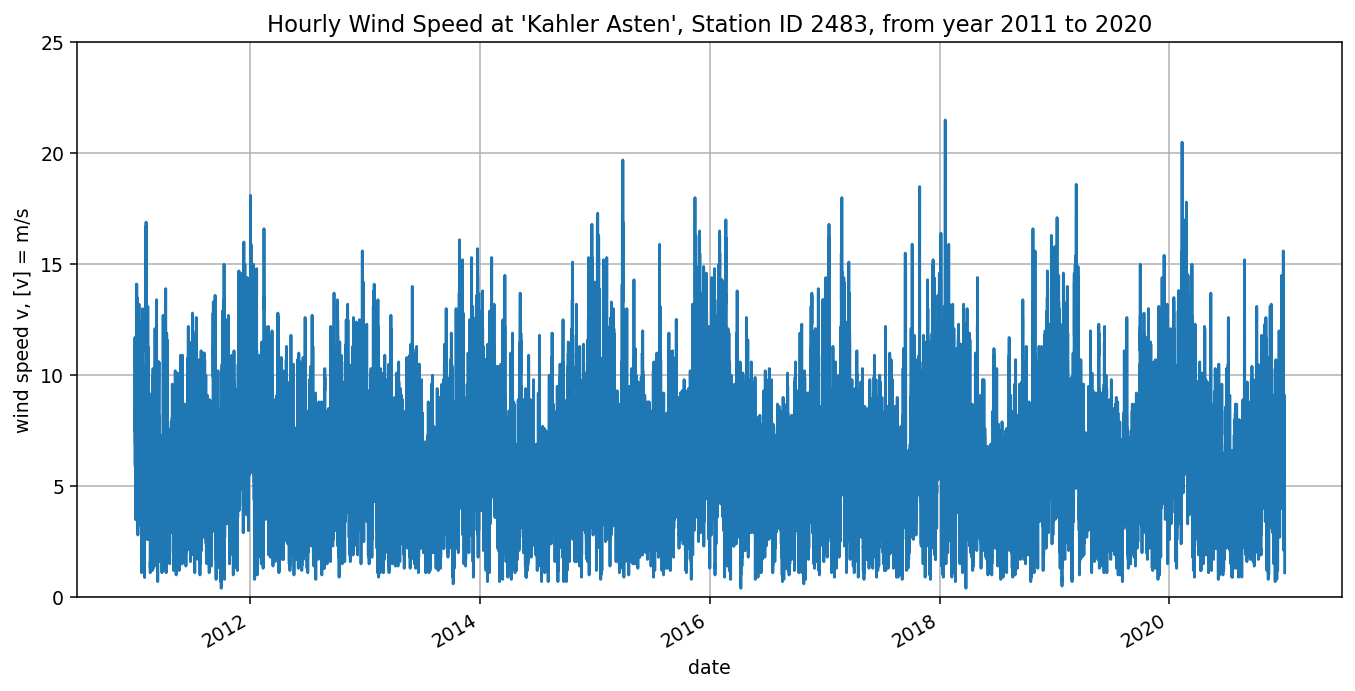

In [15]:
fig1, ax1 = plt.subplots(1,1,figsize=(12,6),dpi=136)
df_wind["wind_speed"].plot(ax = ax1)
ax1.set_title(f"Hourly Wind Speed at 'Kahler Asten', Station ID 2483, from year {year_first} to {year_last}")
ax1.set_ylabel("wind speed v, [v] = m/s")
ax1.set_ylim(0, 25)
ax1.grid(True)
plt.show()

## Classify wind_speed into bins

In [16]:
df_wind["interval"] = pd.cut(df_wind["wind_speed"], bins = np.arange(0,25.1) )

In [17]:
df_wind[["wind_speed", "interval"]]

,wind_speed,interval
date,,
2011-01-01 00:00:00,7.5,"(7.0, 8.0]"
2011-01-01 01:00:00,8.7,"(8.0, 9.0]"
2011-01-01 02:00:00,8.7,"(8.0, 9.0]"
2011-01-01 03:00:00,8.5,"(8.0, 9.0]"
2011-01-01 04:00:00,10.1,"(10.0, 11.0]"
...,...,...
2020-12-31 19:00:00,2.3,"(2.0, 3.0]"
2020-12-31 20:00:00,2.1,"(2.0, 3.0]"
2020-12-31 21:00:00,1.7,"(1.0, 2.0]"


In [18]:
hist = df_wind.groupby("interval")["interval"].count()
hist.rename("freq", inplace= True)
hist

interval
(0.0, 1.0]        154
(1.0, 2.0]       1800
(2.0, 3.0]       5484
(3.0, 4.0]       9985
(4.0, 5.0]      13857
(5.0, 6.0]      14563
(6.0, 7.0]      12867
(7.0, 8.0]       9861
(8.0, 9.0]       7011
(9.0, 10.0]      4721
(10.0, 11.0]     3142
(11.0, 12.0]     1823
(12.0, 13.0]     1060
(13.0, 14.0]      528
(14.0, 15.0]      297
(15.0, 16.0]      147
(16.0, 17.0]       66
(17.0, 18.0]       17
(18.0, 19.0]        5
(19.0, 20.0]        3
(20.0, 21.0]        1
(21.0, 22.0]        1
(22.0, 23.0]        0
(23.0, 24.0]        0
(24.0, 25.0]        0
Name: freq, dtype: int64

In [19]:
df_hist = pd.DataFrame(hist)
df_hist["mid_interval"] = df_hist.index.map(lambda x: x.mid).astype(float) 
df_hist["rel_freq"] = df_hist["freq"]/np.sum(df_hist["freq"])
df_hist

,freq,mid_interval,rel_freq
interval,,,
"(0.0, 1.0]",154,0.5,0.001762
"(1.0, 2.0]",1800,1.5,0.020597
"(2.0, 3.0]",5484,2.5,0.062751
"(3.0, 4.0]",9985,3.5,0.114254
"(4.0, 5.0]",13857,4.5,0.158560
"(5.0, 6.0]",14563,5.5,0.166638
"(6.0, 7.0]",12867,6.5,0.147231
"(7.0, 8.0]",9861,7.5,0.112835
"(8.0, 9.0]",7011,8.5,0.080224


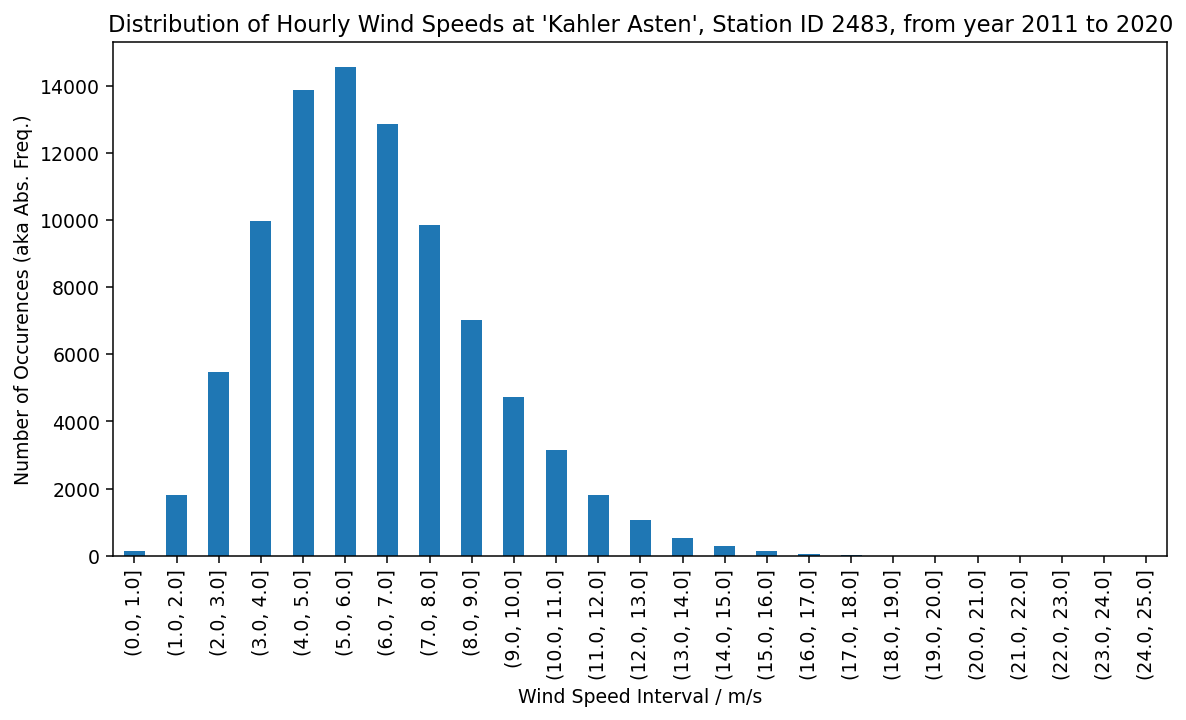

In [20]:
fig2, ax2 = plt.subplots(1,1,figsize=(10,5), dpi=136)
hist.plot(kind = "bar",ax = ax2)
ax2.set_xlabel("Wind Speed Interval / m/s")
ax2.set_ylabel("Number of Occurences (aka Abs. Freq.)")
ax2.set_title(f"Distribution of Hourly Wind Speeds at 'Kahler Asten', Station ID 2483, from year {year_first} to {year_last}")
#ax2.grid(True)
plt.show()

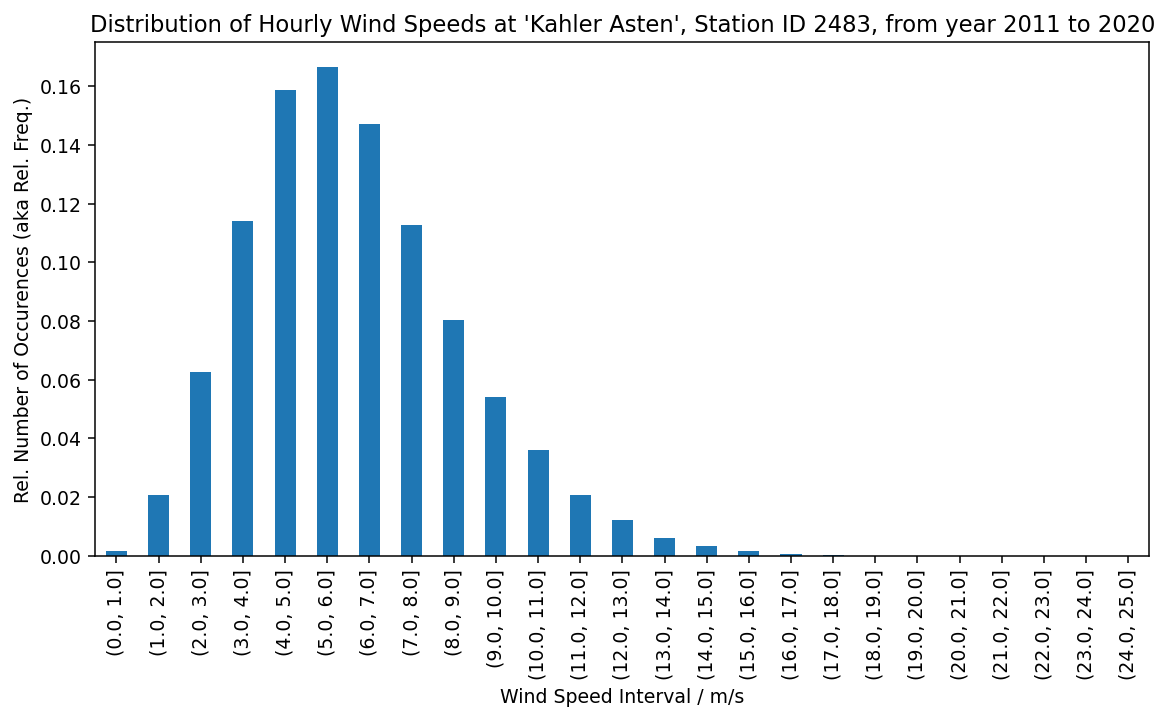

In [21]:
fig3, ax3 = plt.subplots(1,1,figsize=(10,5), dpi=136)
df_hist["rel_freq"].plot(kind = "bar", ax = ax3)
ax3.set_xlabel("Wind Speed Interval / m/s")
ax3.set_ylabel("Rel. Number of Occurences (aka Rel. Freq.)")
ax3.set_title(f"Distribution of Hourly Wind Speeds at 'Kahler Asten', Station ID 2483, from year {year_first} to {year_last}")
#ax2.grid(True)
plt.show()

## Fit probability density functions to the relative frequency

In [22]:
def rayleigh(x,s):
    y = x/s**2*np.exp(-x**2/(2*s**2))
    return(y)

In [23]:
def weibull(v,c=5,k=2):
    """
    Weibull distribution
    c: scale parameter 
    k: shape parameter
    The Weibull distribution is often used to model wind speed distributions.
    The Weibull distribution interpolates between the exponential distribution (k = 1) 
    and the Rayleigh distribution (k = 2 and c =sqrt(2)*s).
    Typical(!) parameter ranges for wind speed in inland Germany: k = 1.1 ... 2 , c = 2 ... 6
    """
    y = k/c*(v/c)**(k-1)*np.exp(-(v/c)**k)
    return(y)

In [24]:
def needleplot(x,y,ax,col="k", sym="x", linewidth=1):
    
    # Plot symbols at P(x,y)
    ax.plot(x,y,col+sym)
    
    # plot vertical lines from P(x,y*0) to P(x,y)
    xi = [x,x]   # multiple line plot
    yi = [y*0,y] # multiple line plot
    
    ax.plot(xi,yi,col,linewidth = linewidth)

    ax.plot()

In [25]:
x = np.arange(0,25.0001,0.1)

In [26]:
xh = df_hist["mid_interval"]
yh = df_hist["rel_freq"]

In [27]:
help(weibull)

Help on function weibull in module __main__:

weibull(v, c=5, k=2)
    Weibull distribution
    c: scale parameter 
    k: shape parameter
    The Weibull distribution is often used to model wind speed distributions.
    The Weibull distribution interpolates between the exponential distribution (k = 1) 
    and the Rayleigh distribution (k = 2 and c =sqrt(2)*s).
    Typical(!) parameter ranges for wind speed in inland Germany: k = 1.1 ... 2 , c = 2 ... 6



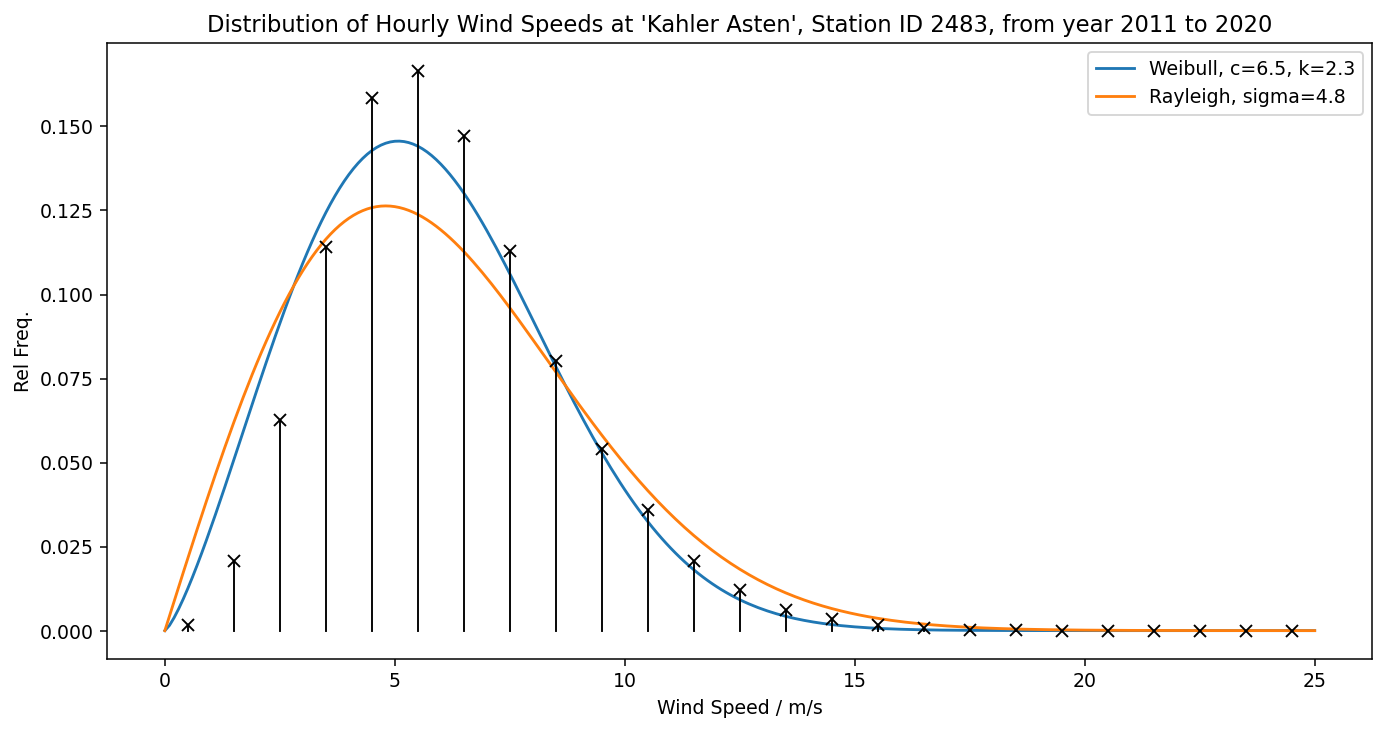

In [28]:
fig3, ax3 = plt.subplots(1,1,figsize=(12,6), dpi=136)


# Rayleigh param
s = 4.8

# Weibull params
c = 6.5   # scale
k = 2.3 # shape

# With these parameters Weibull is Rayleigh
#c = np.sqrt(2)*s
#k = 2


ax3.plot(x,weibull(x,c=c,k=k))
ax3.plot(x,rayleigh(x,s=s))
#ax3.plot(x,weibull(x))

needleplot(xh,yh,ax=ax3)

ax3.set_xlabel("Wind Speed / m/s")
ax3.set_ylabel("Rel Freq.")
ax3.set_title(f"Distribution of Hourly Wind Speeds at 'Kahler Asten', Station ID 2483, from year {year_first} to {year_last}")
ax3.legend([f"Weibull, c={c}, k={k}",f"Rayleigh, sigma={s}"])
#ax2.grid(True)
plt.show()